In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

In [28]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from IPython.display import HTML, display

In [29]:
#定义视频函数
def make_video_from_solution(
    solution,
    quantities=("order_parameter"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

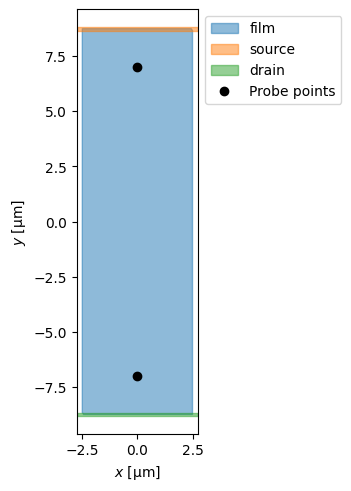

In [30]:
#定义形状和参数
length_units = "um"

# Material parameters
xi = 0.5 #相干长度
london_lambda = 2 #伦敦穿透
d = 0.1 #厚度
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 5
total_length = 3.5 * total_width
link_width = total_width / 3 #这是什么

# Outer geometry of the film
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .resample(401)
    .buffer(0)
)

# Current terminals
source = (
    tdgl.Polygon("source", points=box(1.1 * total_width, total_length / 100))
    .translate(dy=total_length / 2)
)
drain = source.scale(yfact=-1).set_name("drain")

#  Voltage measurement points
probe_points = [(0, total_length / 2.5), (0, -total_length / 2.5)]

device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

fig, ax = device.draw()

Constructing Voronoi polygons: 100%|██████████| 4931/4931 [00:02<00:00, 1973.04it/s]


num_sites,4931
num_elements,9460
min_edge_length,7.006e-02
max_edge_length,2.379e-01
mean_edge_length,1.459e-01
min_area,2.901e-03
max_area,3.585e-02
mean_area,1.774e-02
coherence_length,5.000e-01
length_units,um


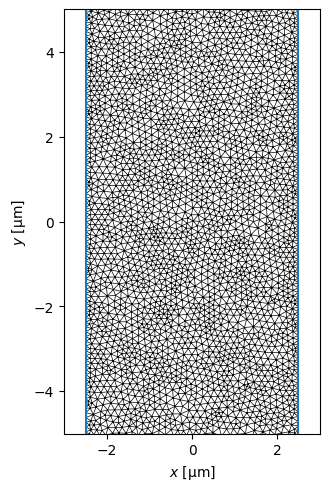

In [31]:
#有限元构造
device.make_mesh(max_edge_length=xi / 2, smooth=100)
fig, ax = device.plot(mesh=True, legend=False)
_ = ax.set_ylim(-5, 5)
device.mesh_stats()

In [219]:
class Setpoints:
    def __init__(self, setpoints):
        '''
        setpoints must be ndarrays with shape N*2
        '''
        self.setpoints = setpoints
        self.plot_time_factor()
    
    def get_func(self):
        return self.time_factor
    
    def time_factor(self, t):
        setpoints = self.setpoints
        if t < setpoints[0, 0]:
            return setpoints[0, 1]
        elif t >= setpoints[-1, 0]:
            return setpoints[-1, 1]
        else:
            for i in range(len(setpoints)):
                ti, Bi = setpoints[i]
                tf, Bf = setpoints[i+1]
                Bi, Bf = float(Bi), float(Bf)
                if ti <= t < tf:
                    return Bi + (Bf-Bi)*(t-ti)/(tf-ti)
                
    def plot_time_factor(self):
        ti = self.setpoints[0, 0]
        tf = self.setpoints[-1, 0]
        T = np.linspace(ti, tf, max(100, 5*len(self.setpoints)))
        B = np.zeros_like(T)
        for i in range(len(T)):
            t = T[i]
            B[i] = self.time_factor(t)
        plt.plot(T, B)

In [213]:
#设置求解参数和外场并求解
options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    #skip_time=100, #先热化后模拟
    solve_time=100,
    output_file=os.path.join('solutions', "weak-link-zero-field.h5"),
    #output_file=None,
    field_units = "mT",
    current_units="uA",
    save_every=100,
)

# varying uniform field according to time_factor
from tdgl.sources import VaryingField

setpoints = np.array([[0, 0], [10, 1], [30, 1], [40, 2], [60, 2], [70, 1], [90, 1], [100, 0]])
func = Setpoints(setpoints)
func.plot_time_factor()
my_sacling = func.get_func()

applied_vector_potential = (
    VaryingField(0.4, time_factor=my_scaling, field_units=options.field_units, length_units=device.length_units)
)

zero_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=applied_vector_potential,
)

Output file already exists. Renaming to solutions\weak-link-zero-field-2.h5.
Simulating: 100%|█████████▉| 100/100 [01:47<00:00,  1.08s/tau ]


In [214]:
time = 60
step = zero_current_solution.closest_solve_step(time)
zero_current_solution.load_tdgl_data(step)
step

131

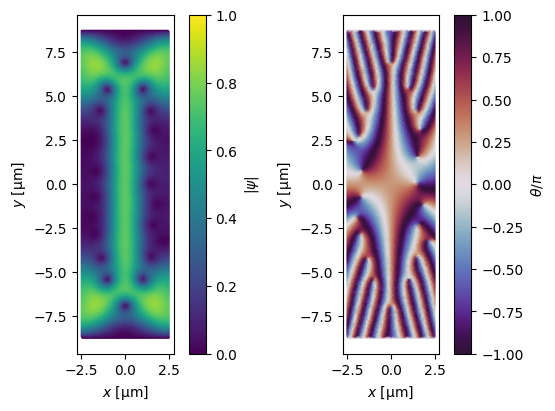

In [215]:
fig, axes = zero_current_solution.plot_order_parameter(figsize=(5.5, 4))

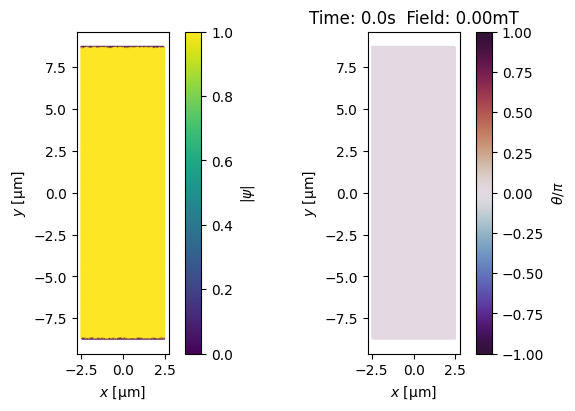

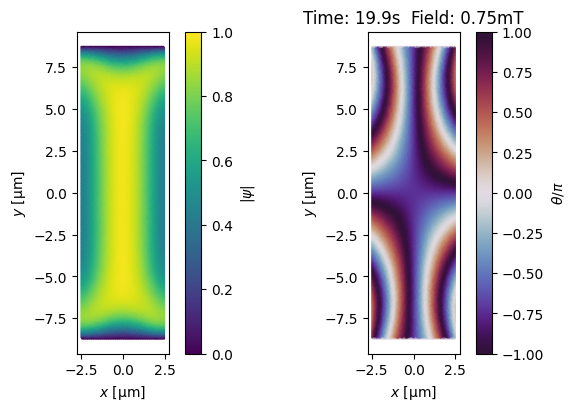

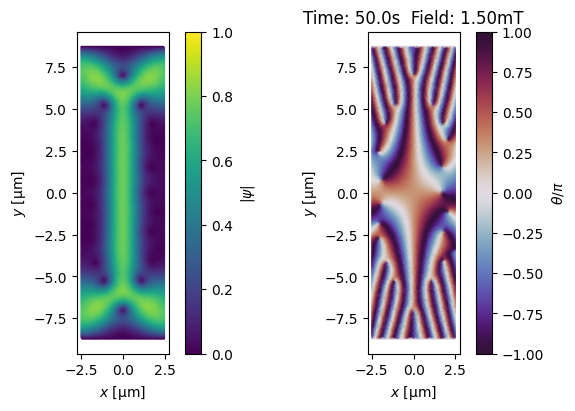

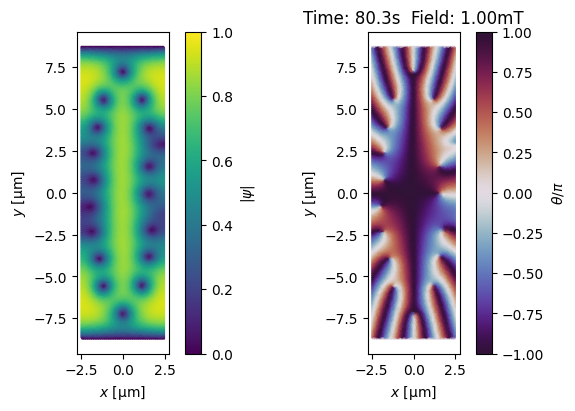

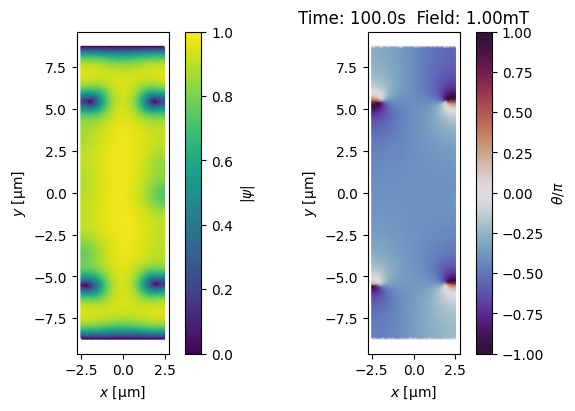

In [216]:
#绘图
def plot_simulations_of_times(solution, setpoints, time_factor, **kwargs):
    for time in setpoints:
        step = solution.closest_solve_step(time)
        solution.load_tdgl_data(step)
        fig, axes = solution.plot_order_parameter(figsize=(6, 4))
        plt.title('Time: {exact_time:.1f}s  Field: {field:.2f}{unit}'.format(exact_time = solution.times[step], field = time_factor(solution.times[step], **kwargs), unit=solution.field_units))

samples = [0, 20, 50, 80, 100]

plot_simulations_of_times(zero_current_solution, samples, scaling)

In [217]:
zero_field_video = make_video_from_solution(
        zero_current_solution,
        quantities=["order_parameter", "phase", "scalar_potential"],
        figsize=(6.5, 4),
    )
display(zero_field_video)